<a href="https://colab.research.google.com/github/ATHdevs/Auto-PCOS/blob/main/InceptionV3_PCOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

In [ ]:
dataset_dir = '/content/drive/MyDrive/Auto PCOS'

In [ ]:
all_images = []
all_labels = []

for label in os.listdir(dataset_dir):
    label_path = os.path.join(dataset_dir, label)
    if os.path.isdir(label_path):
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            all_images.append(image_path)
            all_labels.append(1 if label == 'Unhealthy' else 0)

df = pd.DataFrame({'Image_Path': all_images, 'Label': all_labels})

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_width, img_height = 256, 256
batch_size = 16

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    return img_array

train_images = np.array([preprocess_image(img_path) for img_path in train_df['Image_Path']])
train_labels = np.array(train_df['Label'])

val_images = np.array([preprocess_image(img_path) for img_path in val_df['Image_Path']])
val_labels = np.array(val_df['Label'])

test_images = np.array([preprocess_image(img_path) for img_path in test_df['Image_Path']])
test_labels = np.array(test_df['Label'])

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1792, 299, 299, 3)
(1792,)
(960, 299, 299, 3)
(960,)


In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3)
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=False)

x = layers.LayerNormalization()(x)

x = layers.Conv2D(1024, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((3, 3))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

model.summary()

765419480/765419480 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 resnet-rs-420 (Functional)  (None, 10, 10, 2048)      190213216 
                                                                 
 layer_normalization (Layer  (None, 10, 10, 2048)      4096      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 1024)        18875392  
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 1024)        0         
 D)                                                              
                                                            

In [ ]:
history = model.fit(
    train_images, train_labels,
    epochs=100,
    validation_data=(val_images, val_labels)
)

Epoch 1/50
56/56 [==============================] - 150s 2s/step - loss: 0.7351 - binary_accuracy: 0.7204 - val_loss: 0.6231 - val_binary_accuracy: 0.6897
Epoch 2/50
56/56 [==============================] - 93s 2s/step - loss: 0.3724 - binary_accuracy: 0.8108 - val_loss: 0.4759 - val_binary_accuracy: 0.7567
Epoch 3/50
56/56 [==============================] - 90s 2s/step - loss: 0.2768 - binary_accuracy: 0.8783 - val_loss: 0.5200 - val_binary_accuracy: 0.7790
Epoch 4/50
56/56 [==============================] - 93s 2s/step - loss: 0.2403 - binary_accuracy: 0.8917 - val_loss: 0.4806 - val_binary_accuracy: 0.7723
Epoch 5/50
56/56 [==============================] - 93s 2s/step - loss: 0.1790 - binary_accuracy: 0.9252 - val_loss: 0.5704 - val_binary_accuracy: 0.7634
Epoch 6/50
56/56 [==============================] - 93s 2s/step - loss: 0.1403 - binary_accuracy: 0.9448 - val_loss: 0.5448 - val_binary_accuracy: 0.7656
Epoch 7/50
56/56 [==============================] - 89s 2s/step - loss: 0.1

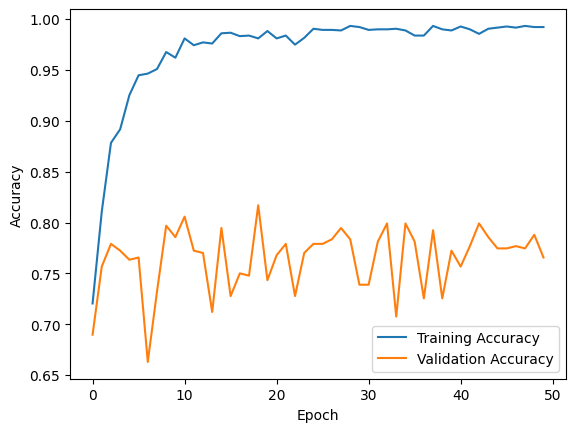

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predicted_probs = model.predict(test_images)
predicted_labels = (predicted_probs > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

30/30 [==============================] - 10s 87ms/step
Evaluation Metrics:
Accuracy: 0.9052083333333333
Precision: 0.9001386962552012
Recall: 0.9715568862275449
F1-score: 0.9344852411807055


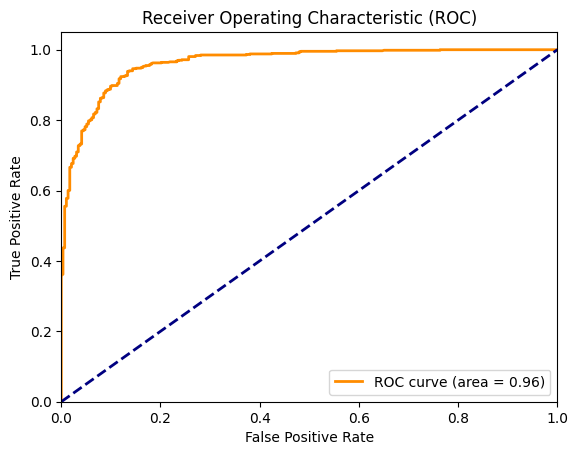

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(test_labels, predicted_probs)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/Auto PCOS/InceptionV3_100.h5')

In [ ]:
!pip install lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


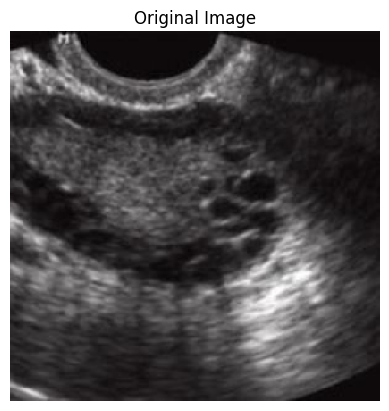

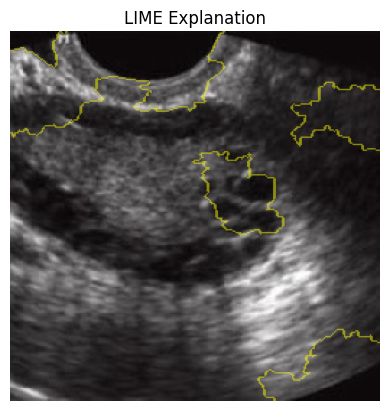

Predicted Class: Healthy, Probability: 0.0000


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


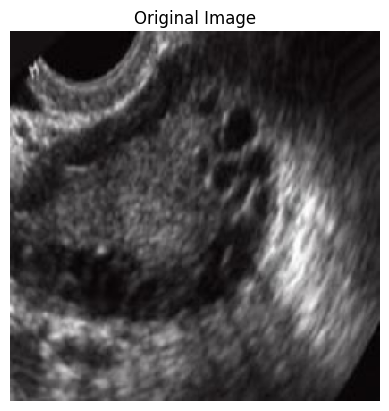

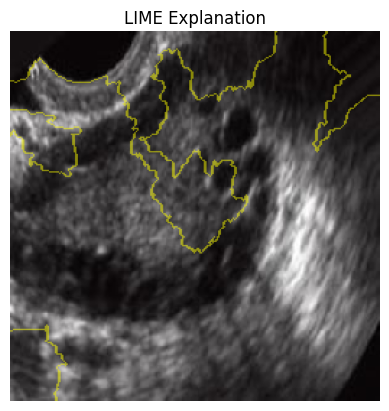

Predicted Class: Healthy, Probability: 0.0000


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


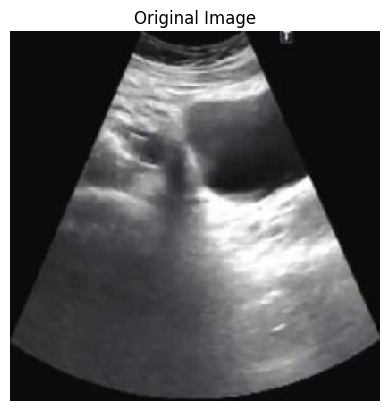

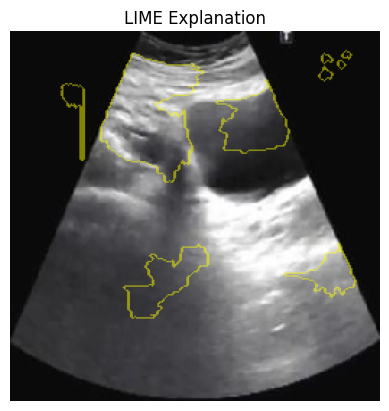

Predicted Class: Unhealthy, Probability: 1.0000


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


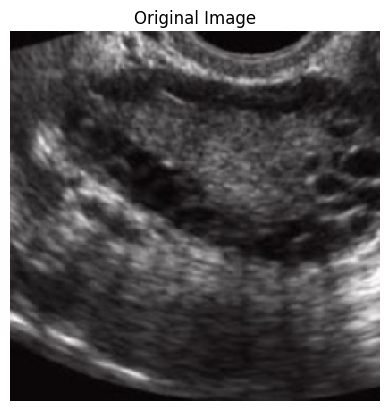

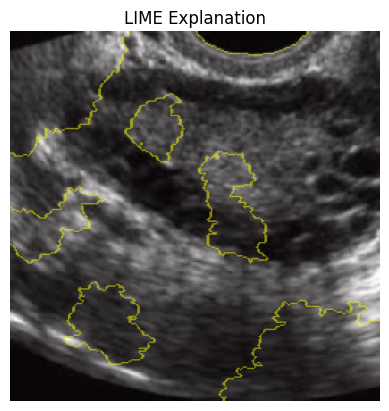

Predicted Class: Healthy, Probability: 0.0003


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


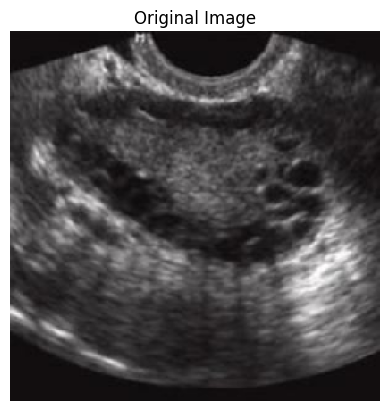

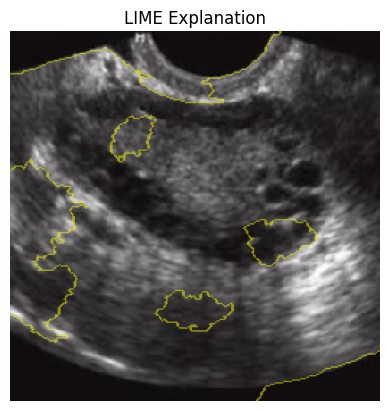

Predicted Class: Healthy, Probability: 0.0000


In [ ]:
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt


preprocess_input_function = tf.keras.applications.inception_v3.preprocess_input

def load_and_preprocess_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input_function(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

def generate_lime_explanation(image_paths, model):
    for image_path in image_paths:

        img_array, original_img = load_and_preprocess_image(image_path)

        original_img.show()

        explainer_lime = lime_image.LimeImageExplainer()
        explanation = explainer_lime.explain_instance(img_array[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
        overlay = mark_boundaries(temp / 2 + 0.5, mask)

        probabilities = model.predict(img_array)[0]
        predicted_class = np.argmax(probabilities)
        predicted_label = "Healthy" if probabilities[predicted_class] < 0.5 else "Unhealthy"
        predicted_label = f'Predicted Class: {predicted_label}, Probability: {probabilities[predicted_class]:.4f}'

        plt.imshow(original_img)
        plt.axis('off')
        plt.title('Original Image')
        plt.show()

        plt.imshow(original_img)
        plt.imshow(overlay, alpha=0.5)
        plt.axis('off')
        plt.title('LIME Explanation')
        plt.show()

        print(predicted_label)

image_paths = ['/content/drive/MyDrive/PCOSGen-test/images/image10499.jpg', '/content/drive/MyDrive/PCOSGen-test/images/image10519.jpg', '/content/drive/MyDrive/PCOSGen-test/images/image10121.jpg', '/content/drive/MyDrive/PCOSGen-test/images/image10210.jpg', '/content/drive/MyDrive/PCOSGen-test/images/image10841.jpg']
generate_lime_explanation(image_paths, model)

In [ ]:
import os
import pandas as pd


test_dir = '/content/drive/MyDrive/PCOSGen-test/images'

predictions_data = []

for i, filename in enumerate(os.listdir(test_dir)):
    if filename.endswith('.jpg') or filename.endswith('.png'):

        img_path = os.path.join(test_dir, filename)
        img_array, img = load_and_preprocess_image(img_path)


        predictions = model.predict(img_array)
        predicted_class = "Unhealthy" if predictions[0][0] > 0.5 else "Healthy"


        predictions_data.append([i+1, filename, predicted_class])


predictions_df = pd.DataFrame(predictions_data, columns=['Sr. No.', 'Image Path', 'Predicted Class'])

predictions_df.to_csv('Predicted.csv', index=False)

1/1 [==============================] - 0s 53ms/step


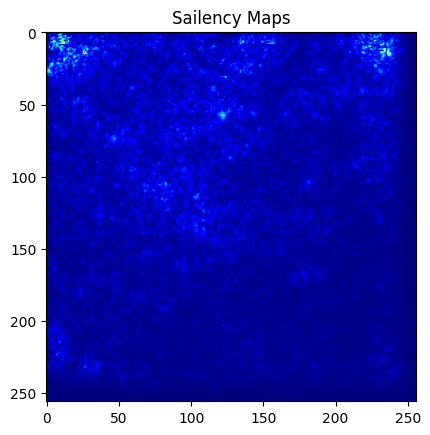

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

preprocess_input_function = tf.keras.applications.inception_v3.preprocess_input

def load_and_preprocess_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input_function(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def compute_saliency_map(model, img_tensor):
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_class = tf.argmax(preds[0])
        top_class_score = preds[:, top_class]

    gradients = tape.gradient(top_class_score, img_tensor)
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)
    return saliency_map

img_path = '/content/drive/MyDrive/PCOSGen-test/images/image10841.jpg'

img_array = load_and_preprocess_image(img_path)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

saliency_map = compute_saliency_map(model, img_tensor)

plt.imshow(saliency_map[0], cmap='jet')
plt.axis()
plt.title("Sailency Maps")
plt.show()